# Building a Chatbot from Scratch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### In this project we will build a chatbot from scratch using the corenell University's Movie Dialogue corpus.
##### We will be using a deep learning based architecture with the main components as a lstm based encoder and decoder.

In [3]:
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Embedding
from keras.layers import Dense, Input, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from collections import Counter
import nltk
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
import keras
import nltk
import numpy
import sklearn

Download the glove model available at https://nlp.stanford.edu/projects/glove/

Specification : Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): glove.twitter.27B.zip


you can download it with 'wget' or can directly put the embedding zip file inside 'embedding_data' folder and unzip it.

In [ ]:
! curl -o '/content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/glove.twitter.27B.zip' http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1449M  100 1449M    0     0  5152k      0  0:04:48  0:04:48 --:--:-- 5339k


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/glove.twitter.27B.zip' -d '/content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/glovetwitter27B'

Archive:  /content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/glove.twitter.27B.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/glovetwitter27B/glove.twitter.27B.25d.txt  
  inflating: /content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/glovetwitter27B/glove.twitter.27B.50d.txt  
  inflating: /content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/glovetwitter27B/glove.twitter.27B.100d.txt  
  inflating: /content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/glovetwitter27B/glove.twitter.27B.200d.txt  


In [6]:
RAND_STATE=np.random.seed(42)
BATCH_SIZE = 32
NUM_EPOCHS = 10
GLOVE_EMBEDDING_SIZE = 100
HIDDEN_UNITS = 256
MAX_INPUT_SEQ_LENGTH = 40
MAX_TARGET_SEQ_LENGTH = 40
MAX_VOCAB_SIZE = 10000
DATA_SET_NAME = '/content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/cornell'
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/cornell_movie_quotes_corpus/References/movie_lines_cleaned.txt'
GLOVE_MODEL = "/content/drive/MyDrive/Colab Notebooks/FinalProject/ChatBot/glovetwitter27B/glove.twitter.27B.100d.txt"
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
WEIGHT_FILE_PATH =  DATA_SET_NAME + '/word-glove-weights.h5'

In [7]:
def in_white_list(_word):
    # Define the set of allowed characters
    white_list_chars = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890')

    # Check if every character in the word is in the whitelist
    return all(char in white_list_chars for char in _word)

Load the glove word embedding in to a dictionary where the **key** is a unique **word token** and the **value** is a **d** dimension vector

# Test-1

In [8]:
import numpy as np

def load_glove_vector():
    _word2embedding = {}
    file = open(GLOVE_MODEL, mode='rt', encoding='utf8')
    for line in file:
        parts = line.strip().split()
        # Check if the line has an expected number of parts (1 word + 100 dimensions)
        if len(parts) == 101:
            word = parts[0]
            vector = np.asarray(parts[1:], dtype='float32')
            _word2embedding[word] = vector
        else:
            print(f"Skipped line: {line.strip()}")
    file.close()
    return _word2embedding

In [9]:
word2embedding = load_glove_vector()
print("Number of words in GloVe:", len(word2embedding))

Skipped line: -0.32053 -0.73053 -0.15227 0.75504 0.11011 0.14091 0.047278 -1.0087 0.13282 -0.10939 -0.010336 0.32189 -1.4589 -0.83385 -0.52429 0.55353 0.054966 0.02489 0.066947 0.39403 -0.2942 -1.2322 -0.2594 -0.72149 0.3671 0.24201 0.023268 0.14087 0.60309 0.37282 0.40474 0.16387 1.5523 -0.28782 -0.26105 -0.83564 -0.031021 0.26182 -0.093516 -0.36343 -0.10013 -0.113 1.3461 -0.7571 -0.51527 -0.0099121 -0.34748 0.2534 0.43839 0.30234 0.0080009 0.51505 0.25082 -0.53778 0.20495 0.27272 0.13311 0.98437 -0.24143 0.041526 0.21953 -0.20118 0.068255 1.2481 -0.28648 -0.058264 0.18604 0.45244 0.36555 0.35107 0.78051 -0.20271 0.99956 -0.4688 -0.49431 -0.14843 0.0022548 -0.10625 -0.21541 -0.24243 -0.68123 -0.17896 -0.86271 0.74024 0.73827 0.4905 -0.71627 -0.49518 0.050481 -0.21521 -1.21 0.38652 -0.22538 0.52208 0.62189 0.44918 -0.229 0.045921 0.73164 -0.23074
Number of words in GloVe: 1193513


# Check-1

In [10]:
assert len(word2embedding.keys())==1193513
for key in word2embedding.keys():
    try:
        assert len(word2embedding[key])==100
    except AssertionError:
        print (key,len(word2embedding[key]))

# Data Preparation

In [11]:
target_counter = Counter()
lines = open(DATA_PATH, 'rt', encoding='utf8').read().split('\n')
input_texts = []
target_texts = []
prev_words = []

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
for line in lines:
    next_words = [w.lower() for w in nltk.word_tokenize(line)]
    if len(next_words) > MAX_TARGET_SEQ_LENGTH:
        next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]
    if len(prev_words) > 0:
        input_texts.append(prev_words)
        target_words = next_words[:]
        target_words.insert(0, 'start')
        target_words.append('end')
        for w in target_words:
            target_counter[w] += 1
        target_texts.append(target_words)
    prev_words = next_words

Filter the conversations till max word length and convert the dialogues pairs into input text and target texts. Put **start** and **end** token to recognise the beginning and end of the sentence token.

## Let's see some of the training examples

In [ ]:
len(target_texts)

304446

In [ ]:
for idx, (input_words, target_words) in enumerate(zip(input_texts, target_texts)):
  if idx < 10:
    print([input_words, target_words])

[['they', 'do', 'not', '!'], ['start', 'they', 'do', 'to', '!', 'end']]
[['they', 'do', 'to', '!'], ['start', 'i', 'hope', 'so', '.', 'end']]
[['i', 'hope', 'so', '.'], ['start', 'she', 'okay', '?', 'end']]
[['she', 'okay', '?'], ['start', 'let', "'s", 'go', '.', 'end']]
[['let', "'s", 'go', '.'], ['start', 'wow', 'end']]
[['wow'], ['start', 'okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.', 'end']]
[['okay', '--', 'you', "'re", 'gon', 'na', 'need', 'to', 'learn', 'how', 'to', 'lie', '.'], ['start', 'no', 'end']]
[['no'], ['start', 'i', "'m", 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', '``', 'persona', "''", '?', 'and', 'you', 'do', "n't", 'know', 'how', 'to', 'quit', '?', 'end']]
[['i', "'m", 'kidding', '.', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', '``', 'persona', "''", '?', 'and', 'you', 'do', "n't", 'know', 'how', 'to', 'quit', '?'], ['start', 'like', 'my', 'fear', 'of', 'wearin

### Create two dictionaries
<ol>
<li>target_word2id
<li>target_id2word
</ol>
and save it as NumPy file format in the disk.
<p>
<strong>NOTE:</strong> The ids should start from 1 beacause <strong>0</strong> is reserved for <strong>'unknown'</strong> tokens.
Make sure you consider only the <strong>most common</strong> tokens with <strong>MAX_VOCAB_SIZE</strong> defined above.

Most common refers to tokens with higher frequency.
</p>
<strong>Help:</strong>
<ol>
<li>Use the target_counter which have the token counts.  
<li>Use target_counter.most_common(MAX_VOCAB_SIZE) to filter common tokens
    </ol>

In [ ]:
import os

# Initialize the dictionary with special tokens
target_word2idx = {}

# Start assigning indices from 1
idx = 1

# Sort the words in target_counter by frequency in descending order
sorted_target_words = sorted(target_counter.most_common(MAX_VOCAB_SIZE), key=lambda x: x[1], reverse=True)

for word, _ in sorted_target_words:
    target_word2idx[word] = idx
    idx += 1

if 'unk' not in target_word2idx:
    target_word2idx['unk'] = 0

# Create target_idx2word dictionary
target_idx2word = {idx: word for word, idx in target_word2idx.items()}

# Create directory if it does not exist
if not os.path.exists(DATA_SET_NAME):
    os.makedirs(DATA_SET_NAME)

np.save( DATA_SET_NAME + '/word-glove-target-word2idx.npy', target_word2idx)
np.save( DATA_SET_NAME + '/word-glove-target-idx2word.npy', target_idx2word)

# Check-2

In [ ]:
assert len (target_word2idx.keys())==len (target_idx2word.keys())==MAX_VOCAB_SIZE+1

# Prepare the input data with embedding
The input data is a list of lists
<ol>
<li> First list is a list of sentences
<li> Each sentence is a list of words
 </ol>

In [ ]:
input_texts_word2em = []
target_texts_word2em = []
encoder_max_seq_length = 0
decoder_max_seq_length = 0
num_decoder_tokens = len(target_word2idx)
EMBEDDING_DIM = 100  # Assuming each word is represented by a 100-dimensional vector

for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    encoder_target_wids = []
    for w in input_words:
        emb = word2embedding.get(w, word2embedding.get('unk', np.zeros(EMBEDDING_DIM)))
        encoder_input_wids.append(emb)
    for word in target_words:
        emb = word2embedding.get(word, np.zeros(EMBEDDING_DIM))  # Get the embedding vector
        encoder_target_wids.append(emb)

    input_texts_word2em.append(encoder_input_wids)
    target_texts_word2em.append(encoder_target_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = {
    'num_decoder_tokens': num_decoder_tokens,
    'encoder_max_seq_length': encoder_max_seq_length,
    'decoder_max_seq_length': decoder_max_seq_length
}

print(context)
np.save(DATA_SET_NAME + '/word-glove-context.npy', context)

{'num_decoder_tokens': 10001, 'encoder_max_seq_length': 40, 'decoder_max_seq_length': 42}


# Check-3

In [ ]:
for input_text,input_text_embed in zip (input_texts,range(len(input_texts_word2em))):
    assert (len(input_text)==len(input_texts_word2em[input_text_embed]))

# Generate Training data per batch

generate_batch takes input embedding data (input_word2em_data) and target text data (target_texts) and returns trainable X and Y.
X is a list of [X1,X2]
where
X1 is encoder_input_data_batch( which is created by putting the word embedding(glove vector) of the input tokens) padded in to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

X2 is decoder_input_data_batch which is created by putting the word embedding(glove vector) of the target_words tokens and padding it to a shape of (BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE)

Y is decoder_target_data_batch which is in shape of (BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens)
which signifies for each target token text  in the batch we have an option of any token from the vocabularu to be the next predicted word

In [ ]:
def generate_batch(input_word2em_data, output_text_data):
    num_batches = len(input_word2em_data) // BATCH_SIZE
    while True:  # Loop forever so the generator never terminates
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            encoder_input_data_batch = np.zeros((BATCH_SIZE, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE), dtype='float32')
            decoder_input_data_batch = np.zeros((BATCH_SIZE, decoder_max_seq_length, GLOVE_EMBEDDING_SIZE), dtype='float32')
            decoder_target_data_batch = np.zeros((BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens), dtype='float32')

            for lineIdx, (input_text, output_text) in enumerate(zip(input_word2em_data[start:end], output_text_data[start:end])):
              for wordIdx, word in enumerate(input_text):
                  # Ensure word is a string
                  if isinstance(word, str):
                      encoder_input_data_batch[lineIdx, wordIdx, :] = word2embedding.get(word, np.zeros((GLOVE_EMBEDDING_SIZE,)))
              for wordIdx, word in enumerate(output_text):
                  # Ensure word is a string
                  if isinstance(word, str):
                      decoder_input_data_batch[lineIdx, wordIdx, :] = word2embedding.get(word, np.zeros((GLOVE_EMBEDDING_SIZE,)))
                      # Use index for 'unk' if word is not in target_word2idx
                      target_idx = target_word2idx.get(word, target_word2idx['unk'])
                      if wordIdx > 0:
                          decoder_target_data_batch[lineIdx, wordIdx - 1, target_idx] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

# Check-4

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(input_texts_word2em, target_texts, test_size=0.2, random_state=42)

In [ ]:
train_gen = generate_batch(Xtrain, Ytrain)

In [ ]:
for i,j in train_gen:
    assert i[0].shape==(BATCH_SIZE,context['encoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert i[1].shape==(BATCH_SIZE,context['decoder_max_seq_length'],GLOVE_EMBEDDING_SIZE)
    assert j.shape==(BATCH_SIZE,context['decoder_max_seq_length'],context['num_decoder_tokens'])
print ('Test Case 4 Passes!')

Test Case 4 Passes!


# Model Architecture

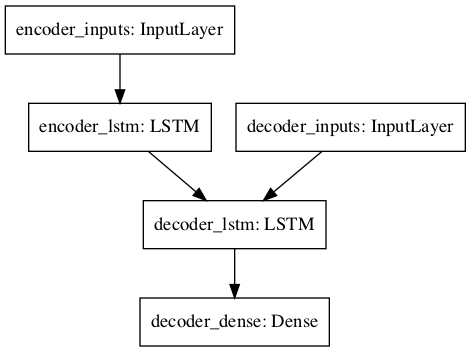

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image
Image(filename='model.png',height=400,width=400)

# The Model architecture is explained in the diagram above

# Test-5

<ol>
<li> Step 1: Use a LSTM encoder to get input words encoded in the form of (encoder outputs, encoder hidden state, encoder context) from input words
<li> Step 2:  Use a LSTM decoder to get target words encoded in the form of (decoder outputs, decoder hidden state, decoder context) from target words. Use encoder hidden states and encoder context (represents input memory) as initial state .
<li> Step 3: Use a dense layer to predict the next token out of the vocabulary given decoder output generated by Step 2.
<li> Step 4: Use loss ='categorical_crossentropy' and optimizer='rmsprop'
</ol>

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

# Define parameters
EMBEDDING_SIZE = 100
ENCODER_UNITS = 256
DECODER_UNITS = 256
VOCAB_SIZE = 10002

# Encoder
encoder_inputs = Input(shape=(None, EMBEDDING_SIZE), name='encoder_inputs')
encoder_lstm = LSTM(ENCODER_UNITS, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, EMBEDDING_SIZE), name='decoder_inputs')
decoder_lstm = LSTM(DECODER_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(VOCAB_SIZE, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Check-5

Check the model summary should look like this

In [ ]:
# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None, 100)]          0         []                            
 )                                                                                                
                                                                                                  
 decoder_inputs (InputLayer  [(None, None, 100)]          0         []                            
 )                                                                                                
                                                                                                  
 encoder_lstm (LSTM)         [(None, 256),                365568    ['encoder_inputs[0][0]']      
                              (None, 256),                                                    

# Train


In [ ]:
# Train the model
BATCH_SIZE = 64  # Set the batch size
EPOCHS = 30  # Set the number of epochs

model.fit([input_texts_word2em, target_texts_word2em], Ytrain,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.2)

# Prediction

## Encoder model

In [ ]:
# Encoder takes the same input as your seq2seq model's encoder
encoder_inputs = model.input[0]  # encoder_inputs layer

# Get the output of the encoder LSTM layer, which are the states
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # encoder_lstm layer

# The states are used as the encoder model's output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

## Decoder model

In [ ]:
# Decoder takes the same input as your seq2seq model's decoder
decoder_inputs = model.input[1]  # decoder_inputs layer

# Additional inputs for the states from the encoder
decoder_state_input_h = Input(shape=(256,))  # Same as LSTM state size
decoder_state_input_c = Input(shape=(256,))  # Same as LSTM state size
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Reuse the decoder LSTM layer from the trained model
decoder_lstm = model.layers[3]  # decoder_lstm layer
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

# Reuse the decoder Dense layer from the trained model
decoder_dense = model.layers[4]  # decoder_dense layer
decoder_outputs = decoder_dense(decoder_outputs)

# The decoder model takes the decoder's inputs and the initial states and outputs the decoded sequence and the new states
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
max_decoder_seq_length = 0
for target_text in target_texts:
    max_decoder_seq_length = max(max_decoder_seq_length, len(target_text))

print("Maximum sequence length for the decoder:", max_decoder_seq_length)

Maximum sequence length for the decoder: 42


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1 with only the start-of-sequence word
    target_seq = np.zeros((1, 1, EMBEDDING_SIZE))
    target_seq[0, 0] = word2embedding.get('<start>', np.zeros(EMBEDDING_SIZE))  # Handle missing embedding

    # Loop and predict next words
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
      output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

      # Sample the next word
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_word = target_idx2word.get(sampled_token_index, 'unk')  # Translate index to word

      # Exit condition: either hit max length or find the stop character
      if (sampled_word == '<end>' or len(decoded_sentence) > max_decoder_seq_length):
          stop_condition = True
      else:
          decoded_sentence.append(sampled_word)

          # Update the target sequence (of length 1)
          target_seq = np.zeros((1, 1, EMBEDDING_SIZE))
          target_seq[0, 0] = word2embedding.get(sampled_word, np.zeros(EMBEDDING_SIZE))  # Handle missing embedding

          # Update states
          states_value = [h, c]

    return decoded_sentence

## Test

In [ ]:
input_text = "Of all the words my father wrote - and there were many - I remember these the most: \"Nothing that results from human progress is achieved with unanimous consent. And those who are enlightened before the others are condemned to persue that light in spite of others. 1697 Of all the words my Father wrote and there were many, I remember these the most.  \"Nothing that results from human progress is achieved with unanimous consent...\""
input_words = nltk.word_tokenize(input_text.lower())
print(input_words)
# Convert words to embeddings
encoder_input_seq = np.zeros((1, encoder_max_seq_length, GLOVE_EMBEDDING_SIZE), dtype='float32')
for i, word in enumerate(input_words):
    if i < encoder_max_seq_length:
        encoder_input_seq[0, i, :] = word2embedding.get(word, np.zeros((GLOVE_EMBEDDING_SIZE,)))
print("Encoded input sentence", encoder_input_seq)
# Decode the sequence
decoded_sentence = decode_sequence(encoder_input_seq)

# Convert list of words back to a sentence
decoded_sentence = ' '.join(decoded_sentence)
print("Decoded sentence:", decoded_sentence)

['of', 'all', 'the', 'words', 'my', 'father', 'wrote', '-', 'and', 'there', 'were', 'many', '-', 'i', 'remember', 'these', 'the', 'most', ':', '``', 'nothing', 'that', 'results', 'from', 'human', 'progress', 'is', 'achieved', 'with', 'unanimous', 'consent', '.', 'and', 'those', 'who', 'are', 'enlightened', 'before', 'the', 'others', 'are', 'condemned', 'to', 'persue', 'that', 'light', 'in', 'spite', 'of', 'others', '.', '1697', 'of', 'all', 'the', 'words', 'my', 'father', 'wrote', 'and', 'there', 'were', 'many', ',', 'i', 'remember', 'these', 'the', 'most', '.', '``', 'nothing', 'that', 'results', 'from', 'human', 'progress', 'is', 'achieved', 'with', 'unanimous', 'consent', '...', "''"]
Encoded input sentence [[[ 1.9323e-01 -2.6532e-01  2.3104e-01 ... -3.2829e-01  1.1387e+00
    5.3168e-01]
  [-4.2218e-01  1.6193e-01 -1.1836e-01 ... -3.2872e-01  6.6699e-01
    1.6698e-01]
  [ 9.5152e-02  3.7024e-01  5.4291e-01 ... -5.1083e-01  4.6877e-01
    3.4882e-01]
  ...
  [ 2.3646e-01  2.3314e-0